# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

# Inferences and Observations:
Noted, below are my inference and observations from the weather conditions of random set of cities around the world. The weather is impacted by factors such as Latitude, hemisphere, closeness to large water bodies.

## Inference:
1. As expected, the weather tends to be significantly warmer near the equator (0 Deg. Latitude). Interestingly, at this time southern hemisphere tends to be warmer than the northern hemisphere. This may be due to the tilt of the earth and this will change in couple of months when the northern hemisphere will get warmer than the southern hemisphere. The tilt of the earth changes for a location as the earth rotates and the distance from the Sun and thus influencing the weather conditions.

2. There is no strong correlationship between latitude and cloudiness. Interesting to see a band of cities sits at 0, 80, and 100% cloudiness.

3. There is no strong relationship between latitude and wind speed. Interestingly, in northern hemispheres there is a number of cities with over 20 mph of wind.

4. There is no strong relationship between latitude and humidity.

## Observations:

1. By large the weather conditions are impacted by the distance of the location from the sun and this drives the changes of weather as the seasons change. These seasons are opposite for North and South hemispheres.
2. The weather is also influenced by local conditions driven by the topology of the land and nearness to a large water body.
3. Humidity seem to influenced by number of factors and would need further study than what was done here.

In [1]:
#Self Notes:

#There are 360° of longitude (180° E ↔ 180° W) and 180° of latitude (90° N ↔ 90° S).    
#Units for Lat (Latitude) is Degrees (°)
#Units for Lag (Longitude) is Degrees (°)
#Units for Max Temp is (°F) Fahrenheit
#Units for Humidity is (%)
#Units for Cloudiness is Okta (eights), though in this study it is the ability to see the sky in percentage is being used.
#Units for Wind Speed is mph
#Date is in YYYY-MM-DD UTC format


In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import linregress
from scipy.stats import pearsonr

from datetime import datetime
from datetime import date
import requests
import time

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [3]:
# List for holding lat_lngs and cities
lats = []
lngs = []
cities = []
countries = []

# Create a set of random lat and lng combinations
lats1 = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs1 = np.random.uniform(low=-180.000, high=180.000, size=1500)

for lat, lng in zip(lats1, lngs1):
    lats.append(lat)
    lngs.append(lng)

In [4]:
# Identify nearest city, country_code for each lat, lng combination
#for lat_lng in lat_lngs:
for lat, lng in zip(lats, lngs):
    #City Name (Title Case)
    city = (citipy.nearest_city(lat, lng).city_name).title().strip()
    #Country code (Upper Case)
    country = (citipy.nearest_city(lat, lng).country_code).upper().strip()
    cities.append(city)
    countries.append(country)

In [5]:
my_df = pd.DataFrame( list(zip(cities, countries)), columns=['City', 'Country'])
my_df.head(10)

,City,Country
0,Aklavik,CA
1,Tsihombe,MG
2,Hermanus,ZA
3,Kapaa,US
4,Ambon,ID
5,Mataura,PF
6,Butaritari,KI
7,Sinnamary,GF
8,Kieta,PG
9,Punta Arenas,CL


In [6]:
# Need to drop duplicate data by City, Country while keping the first record in the sort order. 
#  The data can be duplicated for 2 reasons
#   a. the city can appear more than one time across or within country
#   b. the same nearest city could be identified for a given latitude and longitude data.
weather_df = my_df.drop_duplicates(keep='first')
weather_df.describe(include='all')

,City,Country
count,625,625
unique,623,119
top,Hamilton,RU
freq,2,87


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [7]:
print(f'-----------------------------------------------------------')
print(f'Beginning Data Retrieval - {datetime.now().isoformat()}')
print(f'-----------------------------------------------------------')

# Save config information in variables
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}"

loop_counter = 0
for index, row in weather_df.iterrows():
    
    try:
        # Create the parameters for use with the url for a given City and Country 
        params = { 'url': query_url
                  ,  'q': f"{row['City']}, {row['Country']}"
        }
                     
        # build the url for the get request
        target_url = f"{params['url']}&q={params['q']}"
        
        # Make the get request 
        response = requests.get(target_url)
        # Get the Payload as JSON data
        response_json = requests.get(target_url).json()

        # Add the Weather Data received for the given City, Country
        #Units for Lat (Latitude) is Degrees (°)
        weather_df.loc[index, 'Lat'] = response_json['coord']['lat']
        #Units for Lag (Longitude) is Degrees (°)
        weather_df.loc[index, 'Lng'] = response_json['coord']['lon']
        #Units for Max Temp is (°F) Fahrenheit
        weather_df.loc[index, 'Max Temp'] = response_json['main']['temp_max']
        #Units for Humidity is (%)
        weather_df.loc[index, 'Humidity'] = response_json['main']['humidity']
        #Units for Cloudiness is Okta (eights)
        weather_df.loc[index, 'Cloudiness'] = response_json['clouds']['all']
        #Units for Wind Speed is mph
        weather_df.loc[index, 'Wind Speed'] = response_json['wind']['speed']
        # Date is in YYYY-MM-DD format (Converted from UNIX timestamp at UTC)
        weather_df.loc[index, 'Date'] = datetime.utcfromtimestamp(response_json['dt']).strftime('%Y-%m-%d')

        print(f"City data record #{loop_counter} of {weather_df['City'].count()} done. '|' Added City:{row['City']}, {row['Country']}")

    except (KeyError, IndexError):
        print(f"Missing data record #{loop_counter} of {weather_df['City'].count()}. '|' Skipping City:{row['City']}, {row['Country']}")

    # Increment loop_counter 
    loop_counter +=1
       
    #set for development, to be removed after the development is complete     
#     if loop_counter == 50:
#         break

    # Timer to delay 10 sec the for-loop
    time.sleep(10)
# End of the for-loop

print(f'-----------------------------------------------------------')
print(f'Total records processed:{loop_counter:,} -  {datetime.now().isoformat()} ')
print(f'-----------------------------------------------------------')

-----------------------------------------------------------
Beginning Data Retrieval - 2020-04-11T00:32:04.121644
-----------------------------------------------------------
City data record #0 of 625 done. '|' Added City:Aklavik, CA


C:\Users\sanji\.conda\envs\PythonData2020_1\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\sanji\.conda\envs\PythonData2020_1\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Missing data record #1 of 625. '|' Skipping City:Tsihombe, MG
City data record #2 of 625 done. '|' Added City:Hermanus, ZA
City data record #3 of 625 done. '|' Added City:Kapaa, US
City data record #4 of 625 done. '|' Added City:Ambon, ID
Missing data record #5 of 625. '|' Skipping City:Mataura, PF
City data record #6 of 625 done. '|' Added City:Butaritari, KI
City data record #7 of 625 done. '|' Added City:Sinnamary, GF
City data record #8 of 625 done. '|' Added City:Kieta, PG
City data record #9 of 625 done. '|' Added City:Punta Arenas, CL
Missing data record #10 of 625. '|' Skipping City:Samusu, WS
City data record #11 of 625 done. '|' Added City:Hobart, AU
City data record #12 of 625 done. '|' Added City:Rikitea, PF
Missing data record #13 of 625. '|' Skipping City:Tumannyy, RU
City data record #14 of 625 done. '|' Added City:Vaini, TO
City data record #15 of 625 done. '|' Added City:Saint George, BM
City data record #16 of 625 done. '|' Added City:Totma, RU
City data record #17 of

City data record #132 of 625 done. '|' Added City:Pokhara, NP
City data record #133 of 625 done. '|' Added City:Marinette, US
City data record #134 of 625 done. '|' Added City:Nishihara, JP
City data record #135 of 625 done. '|' Added City:Erdenet, MN
City data record #136 of 625 done. '|' Added City:Hilo, US
Missing data record #137 of 625. '|' Skipping City:Attawapiskat, CA
City data record #138 of 625 done. '|' Added City:Isangel, VU
City data record #139 of 625 done. '|' Added City:Tasiilaq, GL
City data record #140 of 625 done. '|' Added City:Kamen-Rybolov, RU
City data record #141 of 625 done. '|' Added City:Hasaki, JP
City data record #142 of 625 done. '|' Added City:Yenagoa, NG
City data record #143 of 625 done. '|' Added City:Shitanjing, CN
Missing data record #144 of 625. '|' Skipping City:Mentok, ID
City data record #145 of 625 done. '|' Added City:Stokmarknes, NO
City data record #146 of 625 done. '|' Added City:Cururupu, BR
City data record #147 of 625 done. '|' Added City

City data record #261 of 625 done. '|' Added City:Ancud, CL
City data record #262 of 625 done. '|' Added City:Bang Saphan, TH
City data record #263 of 625 done. '|' Added City:Helong, CN
City data record #264 of 625 done. '|' Added City:Chon Buri, TH
City data record #265 of 625 done. '|' Added City:Pampa, US
City data record #266 of 625 done. '|' Added City:Andenes, NO
Missing data record #267 of 625. '|' Skipping City:Rawannawi, KI
City data record #268 of 625 done. '|' Added City:San Rafael Del Sur, NI
City data record #269 of 625 done. '|' Added City:Ponta Do Sol, PT
City data record #270 of 625 done. '|' Added City:Varhaug, NO
City data record #271 of 625 done. '|' Added City:Port-Gentil, GA
City data record #272 of 625 done. '|' Added City:Formosa, AR
City data record #273 of 625 done. '|' Added City:Sabang, ID
City data record #274 of 625 done. '|' Added City:Olafsvik, IS
City data record #275 of 625 done. '|' Added City:Marystown, CA
City data record #276 of 625 done. '|' Added

City data record #391 of 625 done. '|' Added City:Gualeguay, AR
City data record #392 of 625 done. '|' Added City:Shingu, JP
City data record #393 of 625 done. '|' Added City:Puerto Leguizamo, CO
Missing data record #394 of 625. '|' Skipping City:Lasa, CN
City data record #395 of 625 done. '|' Added City:Madang, PG
City data record #396 of 625 done. '|' Added City:Smithers, CA
City data record #397 of 625 done. '|' Added City:Qazvin, IR
City data record #398 of 625 done. '|' Added City:Hamilton, BM
City data record #399 of 625 done. '|' Added City:Siderno, IT
City data record #400 of 625 done. '|' Added City:Finnsnes, NO
City data record #401 of 625 done. '|' Added City:Santa Barbara, MX
City data record #402 of 625 done. '|' Added City:Batticaloa, LK
City data record #403 of 625 done. '|' Added City:Pisco, PE
City data record #404 of 625 done. '|' Added City:Killybegs, IE
City data record #405 of 625 done. '|' Added City:Repnoye, RU
Missing data record #406 of 625. '|' Skipping City:T

Missing data record #521 of 625. '|' Skipping City:San Lazaro, PY
City data record #522 of 625 done. '|' Added City:Callaway, US
City data record #523 of 625 done. '|' Added City:Dutse, NG
City data record #524 of 625 done. '|' Added City:Porto Santo, PT
City data record #525 of 625 done. '|' Added City:Thabazimbi, ZA
City data record #526 of 625 done. '|' Added City:Mazamari, PE
City data record #527 of 625 done. '|' Added City:Nabire, ID
City data record #528 of 625 done. '|' Added City:Dodge City, US
City data record #529 of 625 done. '|' Added City:Divnomorskoye, RU
Missing data record #530 of 625. '|' Skipping City:Candawaga, PH
Missing data record #531 of 625. '|' Skipping City:Tuggurt, DZ
Missing data record #532 of 625. '|' Skipping City:Kapoeta, SD
City data record #533 of 625 done. '|' Added City:Barao De Melgaco, BR
City data record #534 of 625 done. '|' Added City:Palmer, US
City data record #535 of 625 done. '|' Added City:Aksu, CN
City data record #536 of 625 done. '|' Ad

In [8]:
# Drop the rows with NaN values and reset the Index of the DataFrame
weather_df = weather_df.dropna(axis='rows')
weather_df = weather_df.reset_index(drop=True)
weather_df.describe()

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed
count,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000
mean,19.943916,16.842842,59.911785,66.985428,50.553734,7.847741
std,33.473894,90.117583,20.968208,22.617652,36.892665,5.228481
min,-54.800000,-179.170000,-7.600000,11.000000,0.000000,0.220000
25%,-7.840000,-59.520000,45.070000,54.000000,14.000000,4.070000
50%,23.720000,20.040000,61.020000,72.000000,52.000000,6.930000
75%,47.940000,99.750000,77.790000,85.000000,88.000000,10.290000
max,78.220000,178.420000,100.710000,100.000000,100.000000,35.340000


In [9]:
# Steps to re-arrange the columns and add a "City ID" column based on the integer index and sort by Latitude (Ascending)
# Create a temp DataFrame sorted by Latitude
tmp_df = weather_df.sort_values(by='Lat').copy()
# Create a new column and reset index
tmp_df = tmp_df.sort_values(by='Lat').reset_index().drop(['index'], axis=1).copy()
tmp_df['City ID'] = tmp_df.index
weather_df = tmp_df[['City ID', 'City', 'Country', 'Lat', 'Lng', 'Date', 'Max Temp', 'Humidity', 'Cloudiness', 'Wind Speed']]

In [10]:
weather_df.head()

,City ID,City,Country,Lat,Lng,Date,Max Temp,Humidity,Cloudiness,Wind Speed
0,0,Ushuaia,AR,-54.80,-68.30,2020-04-11,42.80,56.0,40.0,5.28
1,1,Punta Arenas,CL,-53.15,-70.92,2020-04-11,39.20,86.0,40.0,13.87
2,2,Rio Gallegos,AR,-51.62,-69.22,2020-04-11,42.80,70.0,54.0,6.93
3,3,Bluff,NZ,-46.60,168.33,2020-04-11,70.00,48.0,5.0,5.01
4,4,Kaitangata,NZ,-46.28,169.85,2020-04-11,53.01,85.0,0.0,3.00


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [11]:
# Write the data to the csv file
weather_df.to_csv(output_data_file, mode='w',index=False)  

print(f'-----------------------------------------------------------------------------------------')
print(f'Saving weather data to CSV file: {output_data_file} -  {datetime.now().isoformat()} ')
print(f'-----------------------------------------------------------------------------------------')

-----------------------------------------------------------------------------------------
Saving weather data to CSV file: output_data/cities.csv -  2020-04-11T02:17:17.300102 
-----------------------------------------------------------------------------------------


In [12]:
weather_df.head()

,City ID,City,Country,Lat,Lng,Date,Max Temp,Humidity,Cloudiness,Wind Speed
0,0,Ushuaia,AR,-54.80,-68.30,2020-04-11,42.80,56.0,40.0,5.28
1,1,Punta Arenas,CL,-53.15,-70.92,2020-04-11,39.20,86.0,40.0,13.87
2,2,Rio Gallegos,AR,-51.62,-69.22,2020-04-11,42.80,70.0,54.0,6.93
3,3,Bluff,NZ,-46.60,168.33,2020-04-11,70.00,48.0,5.0,5.01
4,4,Kaitangata,NZ,-46.28,169.85,2020-04-11,53.01,85.0,0.0,3.00


### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

#### Latitude vs. Temperature Plot

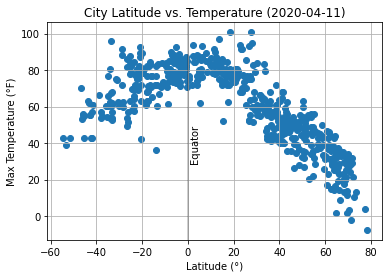

In [13]:
#Plot latitude vs temperature and save as .png
# The code here is analysing any relationship of Latitude vs Temperature
# Indeed the plot does show the cities near near Equator have higher tempeartures

plt.scatter(weather_df['Lat'], weather_df['Max Temp'])
plt.title(f'City Latitude vs. Temperature ({weather_df.iloc[0]["Date"]})')
plt.xlabel('Latitude (°)')
plt.ylabel('Max Temperature (°F)')
plt.axvline(0, color = 'black', alpha = .25, label = 'Equator') #adds equator line
plt.text(1,30,'Equator',rotation=90)
plt.grid(True)

plt.savefig("output_data/fig01-City-Lat-Temp.png", bbox_inches='tight')

#### Latitude vs. Humidity Plot

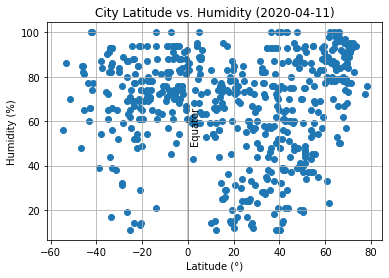

In [14]:
#Plot latitude vs humidity and save as .png
# The code here is analysing any relationship of Latitude vs Humidity
# The scatter plot does not indicate any direct relationship

plt.scatter(weather_df['Lat'], weather_df['Humidity'])
plt.title(f'City Latitude vs. Humidity ({weather_df.iloc[0]["Date"]})')
plt.xlabel('Latitude (°)')
plt.ylabel('Humidity (%)')
plt.axvline(0, color = 'black', alpha = .25, label = 'Equator') #adds equator line
plt.text(1,50,'Equator',rotation=90)
plt.grid(True)

plt.savefig("output_data/fig02-City-Lat-humid.png", bbox_inches='tight')

#### Latitude vs. Cloudiness Plot

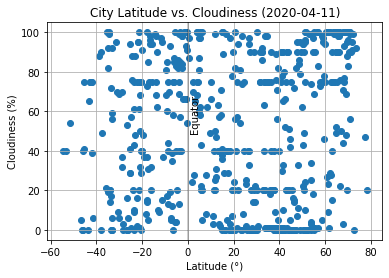

In [15]:
#Plot latitude vs cloudiness and save as .png
# The code here is analysing any relationship of Latitude vs Cloudiness
# The scatter plot does not indicate any direct relationship

plt.scatter(weather_df['Lat'], weather_df['Cloudiness'])
plt.title(f'City Latitude vs. Cloudiness ({weather_df.iloc[0]["Date"]})')
plt.xlabel('Latitude (°)')
plt.ylabel('Cloudiness (%)')
plt.axvline(0, color = 'black', alpha = .25, label = 'Equator') #adds equator line
plt.text(1,50,'Equator',rotation=90)
plt.grid(True)

plt.savefig("output_data/fig03-City-Lat-Cloud.png", bbox_inches='tight')

#### Latitude vs. Wind Speed Plot

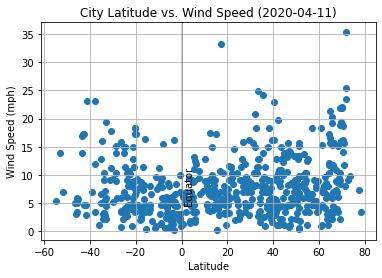

In [16]:
#Plot latitude vs wind speed and save as .png
# The code here is analysing any relationship of Latitude vs Wind Speed
# The scatter plot does not indicate any direct relationship

plt.scatter(weather_df['Lat'], weather_df['Wind Speed'])
plt.title(f'City Latitude vs. Wind Speed ({weather_df.iloc[0]["Date"]})')
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.axvline(0, color = 'black', alpha = .25, label = 'Equator') #adds equator line
plt.text(1,5,'Equator',rotation=90)
plt.grid(True)

plt.savefig("output_data/fig04-City-Lat-Wind.png", bbox_inches='tight')

## Linear Regression

In [17]:
# OPTIONAL: Create a function to create Linear Regression plots


In [18]:
# Create Northern and Southern Hemisphere DataFrames

In [19]:
#Nothern hemissphere data can be filtered out for the cities with Latitudes >= 0°
weather_north_df = weather_df.loc[weather_df.Lat >= 0, :]
weather_north_df.head()

,City ID,City,Country,Lat,Lng,Date,Max Temp,Humidity,Cloudiness,Wind Speed
180,180,Kisangani,CD,0.52,25.20,2020-04-11,74.82,83.0,87.0,1.21
181,181,Muisne,EC,0.60,-80.03,2020-04-11,76.75,86.0,97.0,6.08
182,182,Masindi,UG,1.67,31.71,2020-04-11,71.73,59.0,24.0,4.94
183,183,Mogadishu,SO,2.04,45.34,2020-04-11,87.80,62.0,75.0,6.93
184,184,Bandar,ID,2.05,99.75,2020-04-11,93.54,43.0,70.0,3.42


In [20]:
#Southern hemissphere data can be filtered out for the cities with Latitudes < 0°
weather_south_df = weather_df.loc[weather_df.Lat < 0, :]
weather_south_df.head()

,City ID,City,Country,Lat,Lng,Date,Max Temp,Humidity,Cloudiness,Wind Speed
0,0,Ushuaia,AR,-54.80,-68.30,2020-04-11,42.80,56.0,40.0,5.28
1,1,Punta Arenas,CL,-53.15,-70.92,2020-04-11,39.20,86.0,40.0,13.87
2,2,Rio Gallegos,AR,-51.62,-69.22,2020-04-11,42.80,70.0,54.0,6.93
3,3,Bluff,NZ,-46.60,168.33,2020-04-11,70.00,48.0,5.0,5.01
4,4,Kaitangata,NZ,-46.28,169.85,2020-04-11,53.01,85.0,0.0,3.00


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

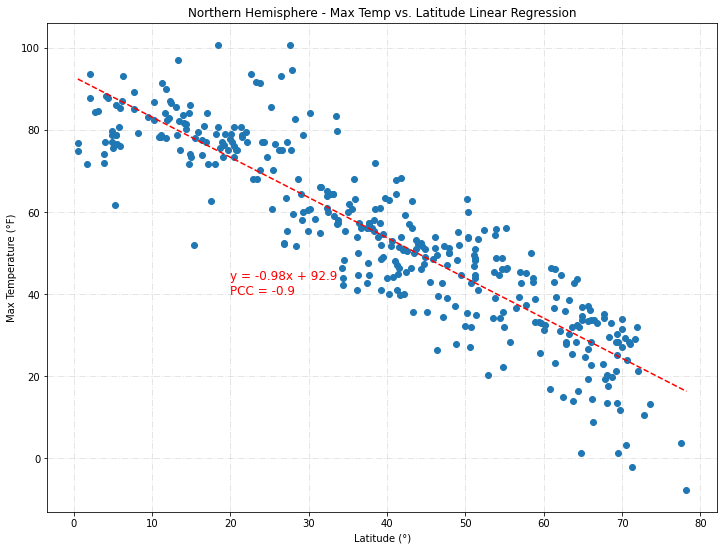

In [29]:
# get the plot data for Latitudes and Max Temp
weather_north_lat = weather_north_df['Lat']
weather_north_temp = weather_north_df['Max Temp']

# Perform a linear regression on City Latitude vs Max Temp
slope, intercept, r, p, std_err = linregress(weather_north_lat, weather_north_temp)

# Calculate correlation coefficient
corr = round(pearsonr(weather_north_lat, weather_north_temp)[0],2)
             
# Create equation of line to calculate predicted Max Temp
fit = slope * weather_north_lat + intercept

# Variable to hold the Line Equation and the PCC
line_eq_pcc_fig5 =  "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)) \
             + "\nPCC = " + str(round(corr,2))

# Create a scatter plot of City Latitudes vs Max Temp
line_fig5, line_ax5, = plt.subplots(1, figsize=(12, 9))
line_ax5.scatter(weather_north_lat, weather_north_temp)
line_ax5.grid(color='grey', ls='-.', lw=1,  alpha=0.2)

# Plot the linear model on top of scatter plot 
plt.plot(weather_north_lat, fit, "r--")

#Show chart and add labels
plt.title(f'Northern Hemisphere - Max Temp vs. Latitude Linear Regression')
plt.xlabel('Latitude (°)')
plt.ylabel('Max Temperature (°F)')
plt.annotate(line_eq_pcc_fig5, (20,40), fontsize=12, color='r')
plt.grid(True)         
                                                
plt.savefig("output_data/fig05-city-lat-temp-north-regress.png", bbox_inches='tight')              

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

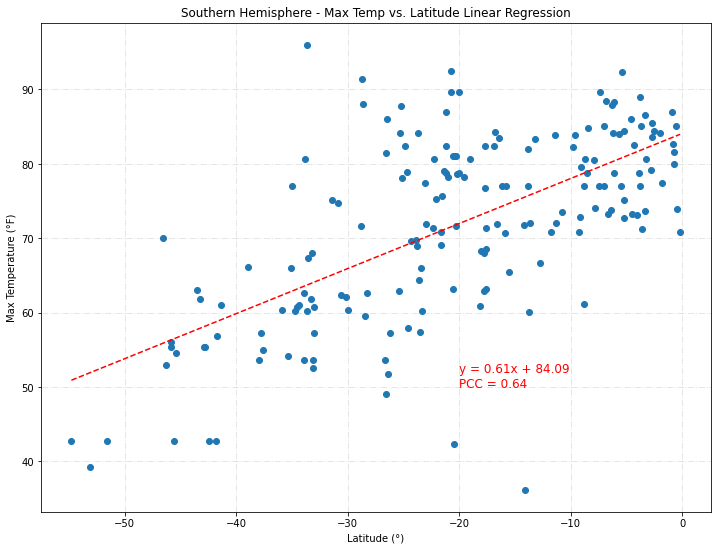

In [33]:
# get the plot data for Latitudes and Max Temp
weather_south_lat = weather_south_df['Lat']
weather_south_temp = weather_south_df['Max Temp']

# Perform a linear regression on City Latitude vs Max Temp
slope, intercept, r, p, std_err = linregress(weather_south_lat, weather_south_temp)

# Calculate correlation coefficient
corr = round(pearsonr(weather_south_lat, weather_south_temp)[0],2)
             
# Create equation of line to calculate predicted Max Temp
fit = slope * weather_south_lat + intercept

# Variable to hold the Line Equation and the PCC
line_eq_pcc_fig6 =  "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)) \
             + "\nPCC = " + str(round(corr,2))

# Create a scatter plot of City Latitudes vs Max Temp
line_fig6, line_ax6, = plt.subplots(1, figsize=(12, 9))
line_ax6.scatter(weather_south_lat, weather_south_temp)
line_ax6.grid(color='grey', ls='-.', lw=1,  alpha=0.2)

# Plot the linear model on top of scatter plot 
plt.plot(weather_south_lat, fit, "r--")

#Show chart and add labels
plt.title(f'Southern Hemisphere - Max Temp vs. Latitude Linear Regression')
plt.xlabel('Latitude (°)')
plt.ylabel('Max Temperature (°F)')
plt.annotate(line_eq_pcc_fig6, (-20,50), fontsize=12, color='r')
plt.grid(True)         
                                                
plt.savefig("output_data/fig06-city-lat-temp-south-regress.png", bbox_inches='tight')              

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

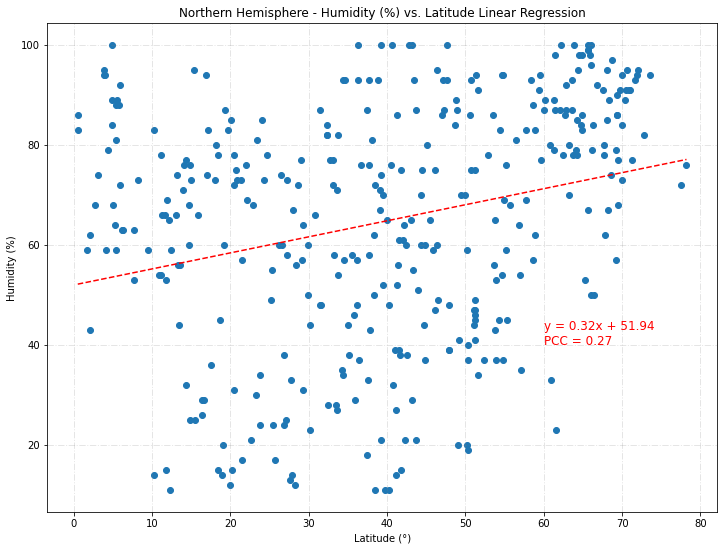

In [34]:
# get the plot data for Latitudes and Humidity
weather_north_lat = weather_north_df['Lat']
weather_north_humid = weather_north_df['Humidity']

# Perform a linear regression on City Latitude vs Humidity
slope, intercept, r, p, std_err = linregress(weather_north_lat, weather_north_humid)

# Calculate correlation coefficient
corr = round(pearsonr(weather_north_lat, weather_north_humid)[0],2)
             
# Create equation of line to calculate predicted Humidity
fit = slope * weather_north_lat + intercept

# Variable to hold the Line Equation and the PCC
line_eq_pcc_fig7 =  "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)) \
             + "\nPCC = " + str(round(corr,2))

# Create a scatter plot of City Latitudes vs Humidity
line_fig7, line_ax7, = plt.subplots(1, figsize=(12, 9))
line_ax7.scatter(weather_north_lat, weather_north_humid)
line_ax7.grid(color='grey', ls='-.', lw=1,  alpha=0.2)

# Plot the linear model on top of scatter plot 
plt.plot(weather_north_lat, fit, "r--")

#Show chart and add labels
plt.title(f'Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression')
plt.xlabel('Latitude (°)')
plt.ylabel('Humidity (%)')
plt.annotate(line_eq_pcc_fig7, (60,40), fontsize=12, color='r')
plt.grid(True)         
                                                
plt.savefig("output_data/fig07-city-lat-humid-north-regress.png", bbox_inches='tight')  

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

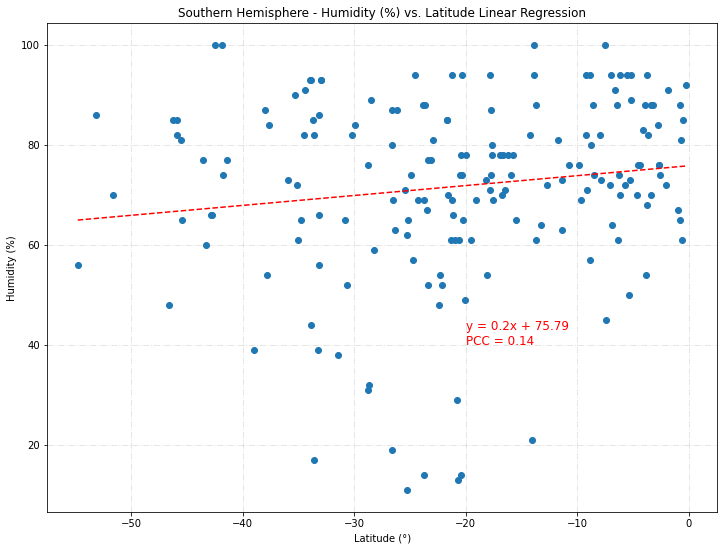

In [38]:
# get the plot data for Latitudes and Humidity
weather_south_lat = weather_south_df['Lat']
weather_south_humid = weather_south_df['Humidity']

# Perform a linear regression on City Latitude vs Humidity
slope, intercept, r, p, std_err = linregress(weather_south_lat, weather_south_humid)

# Calculate correlation coefficient
corr = round(pearsonr(weather_south_lat, weather_south_humid)[0],2)
             
# Create equation of line to calculate predicted Humidity
fit = slope * weather_south_lat + intercept

# Variable to hold the Line Equation and the PCC
line_eq_pcc_fig8 =  "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)) \
             + "\nPCC = " + str(round(corr,2))

# Create a scatter plot of City Latitudes vs Humidity
line_fig8, line_ax8, = plt.subplots(1, figsize=(12, 9))
line_ax8.scatter(weather_south_lat, weather_south_humid)
line_ax8.grid(color='grey', ls='-.', lw=1,  alpha=0.2)

# Plot the linear model on top of scatter plot 
plt.plot(weather_south_lat, fit, "r--")

#Show chart and add labels
plt.title(f'Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression')
plt.xlabel('Latitude (°)')
plt.ylabel('Humidity (%)')
plt.annotate(line_eq_pcc_fig8, (-20,40), fontsize=12, color='r')
plt.grid(True)         
                                                
plt.savefig("output_data/fig08-city-lat-humid-south-regress.png", bbox_inches='tight')  

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

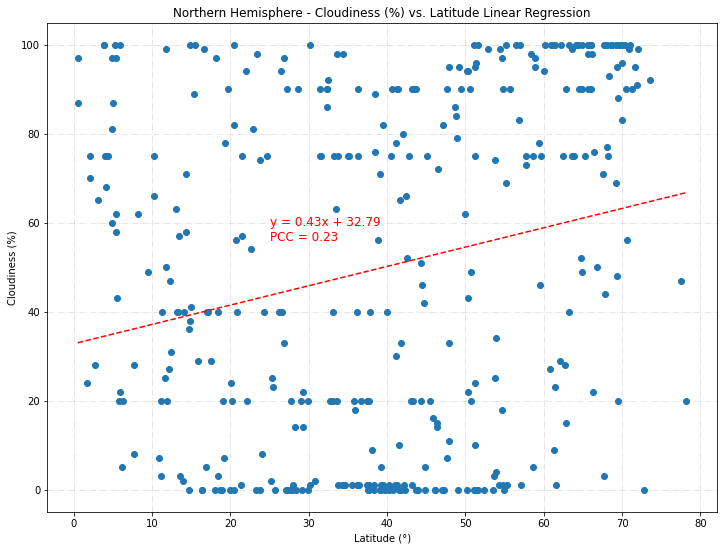

In [39]:
# get the plot data for Latitudes and Cloudiness
weather_north_lat = weather_north_df['Lat']
weather_north_cloudy = weather_north_df['Cloudiness']

# Perform a linear regression on City Latitude vs Cloudiness
slope, intercept, r, p, std_err = linregress(weather_north_lat, weather_north_cloudy)

# Calculate correlation coefficient
corr = round(pearsonr(weather_north_lat, weather_north_cloudy)[0],2)
             
# Create equation of line to calculate predicted Cloudiness
fit = slope * weather_north_lat + intercept

# Variable to hold the Line Equation and the PCC
line_eq_pcc_fig9 =  "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)) \
             + "\nPCC = " + str(round(corr,2))

# Create a scatter plot of City Latitudes vs Cloudiness
line_fig9, line_ax9, = plt.subplots(1, figsize=(12, 9))
line_ax9.scatter(weather_north_lat, weather_north_cloudy)
line_ax9.grid(color='grey', ls='-.', lw=1,  alpha=0.2)

# Plot the linear model on top of scatter plot 
plt.plot(weather_north_lat, fit, "r--")

#Show chart and add labels
plt.title(f'Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression')
plt.xlabel('Latitude (°)')
plt.ylabel('Cloudiness (%)')
plt.annotate(line_eq_pcc_fig9, (25,56), fontsize=12, color='r')
plt.grid(True)         
                                                
plt.savefig("output_data/fig09-city-lat-cloudy-north-regress.png", bbox_inches='tight')  

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

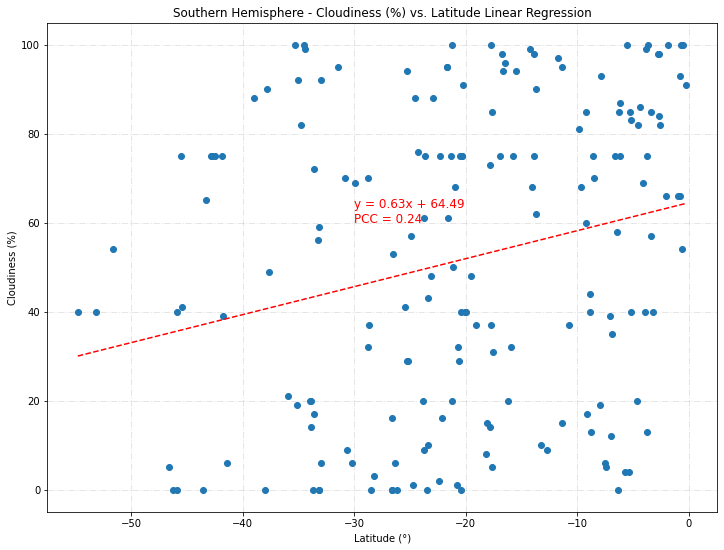

In [40]:
# get the plot data for Latitudes and Cloudiness
weather_south_lat = weather_south_df['Lat']
weather_south_cloudy = weather_south_df['Cloudiness']

# Perform a linear regression on City Latitude vs Cloudiness
slope, intercept, r, p, std_err = linregress(weather_south_lat, weather_south_cloudy)

# Calculate correlation coefficient
corr = round(pearsonr(weather_south_lat, weather_south_cloudy)[0],2)
             
# Create equation of line to calculate predicted Cloudiness
fit = slope * weather_south_lat + intercept

# Variable to hold the Line Equation and the PCC
line_eq_pcc_fig10 =  "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)) \
             + "\nPCC = " + str(round(corr,2))

# Create a scatter plot of City Latitudes vs Cloudiness
line_fig10, line_ax10, = plt.subplots(1, figsize=(12, 9))
line_ax10.scatter(weather_south_lat, weather_south_cloudy)
line_ax10.grid(color='grey', ls='-.', lw=1,  alpha=0.2)

# Plot the linear model on top of scatter plot 
plt.plot(weather_south_lat, fit, "r--")

#Show chart and add labels
plt.title(f'Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression')
plt.xlabel('Latitude (°)')
plt.ylabel('Cloudiness (%)')
plt.annotate(line_eq_pcc_fig10, (-30,60), fontsize=12, color='r')
plt.grid(True)         
                                                
plt.savefig("output_data/fig10-city-lat-cloudy-south-regress.png", bbox_inches='tight')  

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

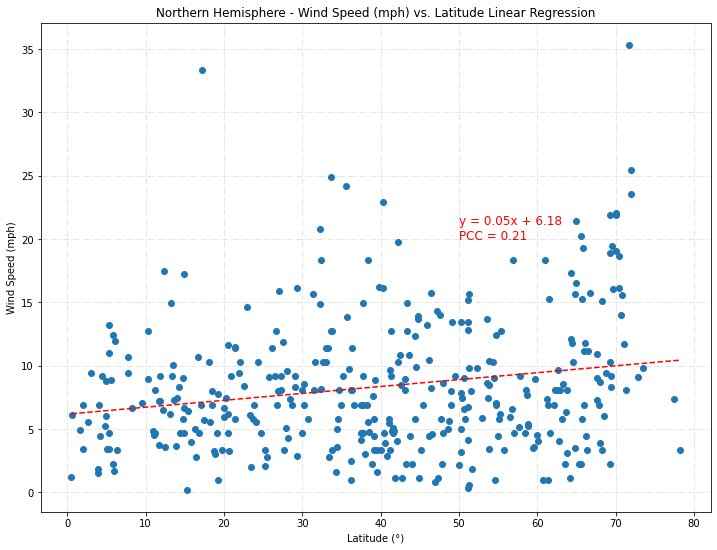

In [41]:
# get the plot data for Latitudes and Wind Speed
weather_north_lat = weather_north_df['Lat']
weather_north_windy = weather_north_df['Wind Speed']

# Perform a linear regression on City Latitude vs Wind Speed
slope, intercept, r, p, std_err = linregress(weather_north_lat, weather_north_windy)

# Calculate correlation coefficient
corr = round(pearsonr(weather_north_lat, weather_north_windy)[0],2)
             
# Create equation of line to calculate predicted Wind Speed
fit = slope * weather_north_lat + intercept

# Variable to hold the Line Equation and the PCC
line_eq_pcc_fig11 =  "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)) \
             + "\nPCC = " + str(round(corr,2))

# Create a scatter plot of City Latitudes vs Wind Speed
line_fig11, line_ax11, = plt.subplots(1, figsize=(12, 9))
line_ax11.scatter(weather_north_lat, weather_north_windy)
line_ax11.grid(color='grey', ls='-.', lw=1,  alpha=0.2)

# Plot the linear model on top of scatter plot 
plt.plot(weather_north_lat, fit, "r--")

#Show chart and add labels
plt.title(f'Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression')
plt.xlabel('Latitude (°)')
plt.ylabel('Wind Speed (mph)')
plt.annotate(line_eq_pcc_fig11, (50,20), fontsize=12, color='r')
plt.grid(True)         
                                                
plt.savefig("output_data/fig11-city-lat-windy-north-regress.png", bbox_inches='tight')  

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

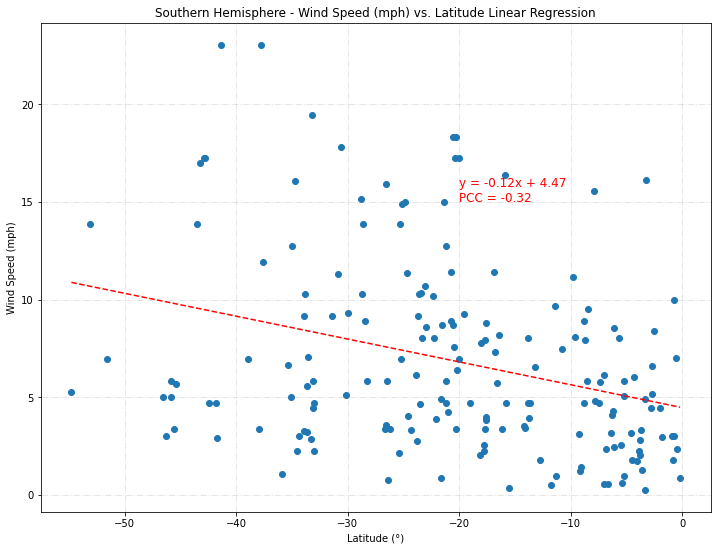

In [42]:
# get the plot data for Latitudes and Wind Speed
weather_south_lat = weather_south_df['Lat']
weather_south_windy = weather_south_df['Wind Speed']

# Perform a linear regression on City Latitude vs Wind Speed
slope, intercept, r, p, std_err = linregress(weather_south_lat, weather_south_windy)

# Calculate correlation coefficient
corr = round(pearsonr(weather_south_lat, weather_south_windy)[0],2)
             
# Create equation of line to calculate predicted Wind Speed
fit = slope * weather_south_lat + intercept

# Variable to hold the Line Equation and the PCC
line_eq_pcc_fig12 =  "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)) \
             + "\nPCC = " + str(round(corr,2))

# Create a scatter plot of City Latitudes vs Wind Speed
line_fig12, line_ax12, = plt.subplots(1, figsize=(12, 9))
line_ax12.scatter(weather_south_lat, weather_south_windy)
line_ax12.grid(color='grey', ls='-.', lw=1,  alpha=0.2)

# Plot the linear model on top of scatter plot 
plt.plot(weather_south_lat, fit, "r--")

#Show chart and add labels
plt.title(f'Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression')
plt.xlabel('Latitude (°)')
plt.ylabel('Wind Speed (mph)')
plt.annotate(line_eq_pcc_fig12, (-20,15), fontsize=12, color='r')
plt.grid(True)         
                                                
plt.savefig("output_data/fig12-city-lat-windy-south-regress.png", bbox_inches='tight')  